# MOSTA (Stereoseq) Analysis Tutorial

<p style="color:#1E90FF;">
<b>Data availability:</b> All processed spatial transcriptomics datasets are publicly available on Zenodo:
<a href="https://doi.org/10.5281/zenodo.17522268" style="color:#1E90FF; text-decoration:underline;">
https://doi.org/10.5281/zenodo.17522268
</a>
</p>

In [1]:
from models.SCILD_main import *
from models.help_func import create_LRDatabase_D, compute_spatial_autocorrelation
import scanpy as sc
import squidpy as sq
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

## Import data

In [2]:
adata = sc.read_h5ad('./data/MOSTAStereoseq_adata_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 1800 × 11091
    obs: 'annotation'
    uns: 'annotation_colors'
    obsm: 'spatial'

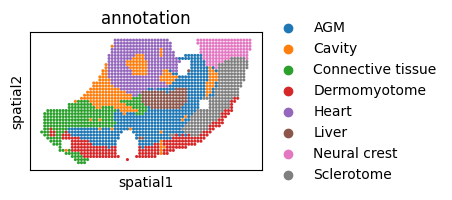

In [3]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(adata, spot_size=1, color=['annotation'], img_key=None)

## Create L-R database

In [4]:
LRDatabase_D = create_LRDatabase_D(
    adata,
    min_cell_pct=0.01,
    database='CellChat',
    species='mouse'
)

In [5]:
LRDatabase_D.shape

(52, 73)

## Run SCILD

In [6]:
CCCProb = SCILD(adata=adata,
                LRDatabase_D=LRDatabase_D,
                neighbor_k=10,
                alpha_q=0.1,
                alpha_f=0.1,
                alpha_g=0.1,
                niter_max=100,
                eps=1e-4,
                verbose=True,
                plot_error=True
                )
CCCProb.preparing()
nl = CCCProb.nl
nr = CCCProb.nr
ns = CCCProb.ns
print('The number of ligand is: ' + str(nl))
print('The number of receptor is: ' + str(nr))
print('The number of spot is: ' + str(ns))

*************Preparing*************
neighbor_k: 10
The number of ligand is: 52
The number of receptor is: 73
The number of spot is: 1800


In [7]:
CCCProb.rho

<1800x1800 sparse matrix of type '<class 'numpy.float64'>'
	with 421398 stored elements in Compressed Sparse Column format>


*************Solving*************
The relative error is: 0.057913579726643565
The relative error is: 0.032907434168877134
The relative error is: 0.023664535909631936
The relative error is: 0.018686557739523574
The relative error is: 0.01551852909818684
The relative error is: 0.013305616577467962
The relative error is: 0.011662519736065904
The relative error is: 0.010390169550352428
The relative error is: 0.009373708030977094
The relative error is: 0.008541819268939457

 The final relative error is: 0.008541819268939457
The total iteration step is: 100


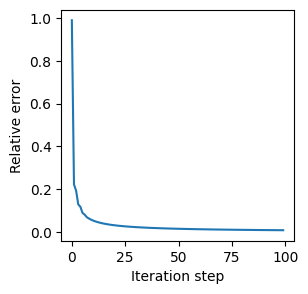

In [8]:
mu0 = np.random.random(nl * ns).reshape(-1, 1)
v0 = np.random.random(nr * ns).reshape(-1, 1)
CCCProb.solving_optimization(mu0, v0)

In [9]:
CCCProb.adata

AnnData object with n_obs × n_vars = 1800 × 11091
    obs: 'annotation'
    uns: 'annotation_colors'
    obsm: 'spatial', 'sum-sender-Q', 'sum-sender-P', 'sum-receiver'

## Extract LR CCC

In [10]:
CCCProb.query_all_LR()

In [11]:
CCCProb.tensor_P.shape

(1800, 1800, 52, 73)

In [12]:
res_dict = tensor_to_method_result(CCCProb.tensor_P, 
                                   list(CCCProb.LRDatabase_D.index), 
                                   list(CCCProb.LRDatabase_D.columns))
len(res_dict)

3796

In [13]:
res_dict = filter_method_result_by_LR_database(res_dict, CCCProb.LRDatabase_D)
len(res_dict)

196

In [14]:
import pickle
with open("./results/MOSTAStereoseq_SCILD_result.pkl", "wb") as f:
    pickle.dump(res_dict, f)

## Visualization

select L-Rs to show (spatial)

In [15]:
CCC_df = CCCProb.compute_TSSR()
CCC_adata = sc.AnnData(CCC_df)
CCC_adata.obsm['spatial'] = adata.obsm['spatial']
CCC_adata

AnnData object with n_obs × n_vars = 1800 × 392
    obsm: 'spatial'

In [16]:
LR_df_spatial = compute_spatial_autocorrelation(CCC_adata)
LR_df_spatial.sort_values('moran_I', ascending=False).head()

,moran_I,p_value
Fgf10->Fgfr2 (R),0.871836,0.0
Igf2->Itgb3 (S),0.849619,0.0
Mif->Ackr3 (S),0.824791,0.0
Igf2->Igf2r (S),0.822429,0.0
Fgf2->Fgfr2 (R),0.787582,0.0


In [17]:
CCCProb.adata.obs[CCC_df.columns] = CCC_df
CCCProb.adata.obs.head()

,annotation,Angpt1->Tek (S),Angpt1->Tek (R),Angptl2->Itga5 (S),Angptl2->Itga5 (R),Angptl2->Itgb1 (S),Angptl2->Itgb1 (R),Angptl4->Cdh11 (S),Angptl4->Cdh11 (R),Angptl4->Cdh5 (S),...,Wnt6->Fzd6 (S),Wnt6->Fzd6 (R),Wnt6->Fzd7 (S),Wnt6->Fzd7 (R),Wnt6->Fzd8 (S),Wnt6->Fzd8 (R),Wnt6->Lrp5 (S),Wnt6->Lrp5 (R),Wnt6->Lrp6 (S),Wnt6->Lrp6 (R)
cell_name,,,,,,,,,,,,,,,,,,,,,
149_96,Connective tissue,8.292575e-32,4.404096e-08,9.791700e-02,3.548117e-01,7.212879e-01,6.343067e-01,4.276637e-83,5.478329e-02,1.940599e-84,...,3.857117e-02,1.419980e-10,1.716632e-01,1.071790e-01,2.528552e-02,1.420040e-10,5.769405e-02,1.441067e-10,2.056201e-02,1.441099e-10
149_97,Connective tissue,7.842926e-32,1.531621e-08,2.963054e-42,2.725040e-09,1.851269e-41,5.499427e-01,4.389269e-83,4.849022e-10,1.911175e-84,...,7.448078e-02,1.051193e-10,2.776903e-01,1.075259e-01,3.547998e-02,1.051327e-10,1.007447e-01,1.072201e-10,3.816787e-02,1.072188e-10
149_98,Connective tissue,7.874489e-01,6.623214e-01,3.139935e-42,4.318802e-09,1.728480e-41,3.424137e-01,4.150145e-83,9.601883e-02,1.892009e-84,...,6.997575e-02,1.070293e-10,2.495540e-01,1.339517e-01,2.572945e-02,1.070190e-10,1.101124e-01,1.115647e-10,3.338618e-02,1.115737e-10
150_112,Dermomyotome,4.075063e-37,5.830013e-08,2.840296e-44,2.838798e-09,3.377251e-42,2.804100e-09,2.734752e-83,7.118963e-05,7.337092e-88,...,1.456950e-92,1.987944e-11,9.528977e-87,2.344476e-11,2.531886e-88,1.988059e-11,4.116900e-87,2.344359e-11,1.892316e-88,2.012374e-11
150_95,Connective tissue,8.275560e-32,6.023706e-08,8.056125e-02,5.376056e-09,6.513164e-01,6.737176e-01,4.029761e-83,6.625678e-02,1.432219e-84,...,4.513681e-02,3.106310e-10,2.771546e-01,1.049772e-01,3.819814e-02,1.049772e-01,1.105208e-01,3.196844e-10,5.247292e-02,3.196825e-10


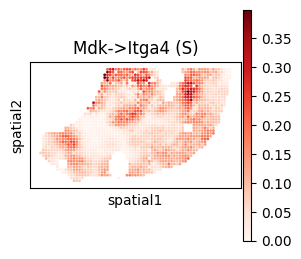

In [18]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=1, color="Mdk->Itga4 (S)", cmap='Reds', img_key=None)

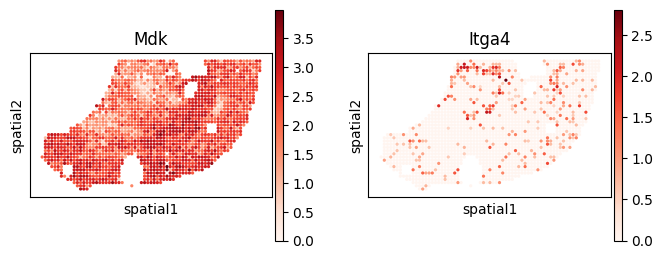

In [19]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=1, color=["Mdk", "Itga4"], cmap='Reds', img_key=None)

## Cell-group level results

In [20]:
from models.help_func import aggregate_to_group

cell_to_group = adata.obs['annotation'].to_dict()
group_result = {}
for lr_key, matrix in res_dict.items():
    group_matrix = aggregate_to_group(matrix, cell_to_group)
    group_result[lr_key] = group_matrix.values